# Baselines: Random Noise & raw precip -> SM

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

# Data

In [2]:
run_dir = Path("/datadrive/data/runs/complexity_AZURE/hs_064_0306_205514")

# GET config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

# GET preds
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

# GET trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)

100%|██████████| 669/669 [00:00<00:00, 1979.95it/s]


Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_064_0306_205514/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

### CAMELS GB

In [3]:
from scripts.cell_state.normalize import normalize_xr_by_basin

ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))
norm_ds = normalize_xr_by_basin(ds)

### Get the cell state data

In [4]:
from scripts.cell_state.extract_cell_state import get_cell_states
from scripts.cell_state.normalize import (normalize_xarray_cstate, normalize_xr_by_basin)

out_dir = run_dir / "cell_states"
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")

cs_data = cn.copy()
norm_cs_data = normalize_xarray_cstate(cs_data, cell_state_var="c_n")

norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
if "date" in norm_cs_data.dims:
    norm_cs_data = norm_cs_data.rename({"date": "time"})

Normalize: 100%|██████████| 64/64 [00:00<00:00, 1770.71it/s]


### normalised ESA CCI SM

In [5]:
# soil moisture data
data_dir = Path("/datadrive/data")

# load in esa cci
esa_ds = xr.open_dataset(data_dir / "camels_basin_ESACCI_sm.nc")    
esa_ds["station_id"] = esa_ds.station_id.astype("int64")
esa_ds = esa_ds.sortby("time")

# normalise sm data
norm_sm = normalize_xr_by_basin(esa_ds)
norm_sm["station_id"] = [int(sid) for sid in norm_sm["station_id"]]

# Baseline 1: Precip Model

#### create X, y samples (timeseries)from typing import Tuple

In [6]:
from scripts.cell_state.timeseries_dataset import get_matching_dim
from scripts.cell_state.cell_state_dataset import fill_gaps

fill = "interpolate"
target_var = "sm"
input_vars = ["precipitation"]

# matching data
target_time, input_time = get_matching_dim(norm_sm, norm_cs_data, "time")
target_sids, input_sids = get_matching_dim(norm_sm, norm_cs_data, "station_id")

input_data = norm_cs_data.sel(time=input_time, station_id=input_sids)
target_data = norm_sm.sel(time=target_time, station_id=target_sids)

start_date = pd.Timestamp("1998-01-01")
end_date = pd.Timestamp("2008-12-31")

input_data = norm_ds.sel(time=slice(start_date, end_date))[input_vars]
input_data = fill_gaps(input_data, fill="interpolate")

target_data = norm_sm["sm"].sel(time=slice(start_date, end_date))
target_data = fill_gaps(target_data, fill="interpolate")

target_data.to_netcdf(data_dir / "SOIL_MOISTURE/interpolated_esa_cci_sm.nc")
input_data.to_netcdf(data_dir / "SOIL_MOISTURE/interpolated_normalised_camels_gb.nc")

Filling gaps with method interpolate: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s, precipitation]


### DataLoader/Dataset

In [7]:
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset

In [92]:
dataset = TimeSeriesDataset(
    input_data=input_data,
    target_data=target_data,
    target_variable="sm",
    input_variables=["precipitation"],
    seq_length=64,
    basin_dim="station_id",
    time_dim="time",
)

train_dl = DataLoader(dataset, batch_size=256)

Creating Samples: 100%|██████████| 670/670 [00:03<00:00, 167.84it/s]


In [91]:
from scripts.cell_state.timeseries_dataset import get_train_test_dataloader

batch_size = 256
train_dl, test_dl = get_train_test_dataloader(
    input_data=input_data,
    target_data=target_data,
    target_variable="sm",
    input_variables=["precipitation"],
    seq_length=64,
    basin_dim="station_id",
    time_dim="time",
    batch_size=batch_size,
    train_start_date=pd.to_datetime("01-01-1998"),
    train_end_date=pd.to_datetime("12-31-2006"),
    test_start_date=pd.to_datetime("01-01-2007"),
    test_end_date=pd.to_datetime("01-01-2009"),
)

Creating Test Samples: 100%|██████████| 670/670 [00:02<00:00, 317.56it/s]


### train model

In [10]:
%load_ext autoreload
%autoreload 2
from scripts.cell_state.cell_state_model import LinearModel

In [43]:
device = "cuda:0"

D_in = np.product(data["x_d"].shape[1:]) if data["x_d"].shape[0] == batch_size else np.product(data["x_d"].shape[1:])
lm = LinearModel(D_in=D_in)
lm.to(device)

data = train_dl.__iter__().__next__()
# set device (model & data)
for key in [k for k in data.keys() if k != "meta"]:
    data[key] = data[key].to(device)

preds = lm(data)

### train model

In [93]:
import torch
from tqdm import tqdm

learning_rate = 1e-2
l2_penalty = 1
n_epochs = 3

loss_fn = torch.nn.MSELoss(reduction="sum").to(device)

optimizer = torch.optim.Adam(
    lm.parameters(), lr=learning_rate, weight_decay=l2_penalty
)

losses = []
for epoch in range(n_epochs):
    pbar = tqdm(train_dl, desc=f"Training Model Epoch {epoch}")
    _losses = []
    for data in pbar:
        for key in [k for k in data.keys() if k != "meta"]:
            data[key] = data[key].to(device)

        y_pred = lm(data).squeeze()
        y = data["y"][:, -1, :].squeeze()
        loss = loss_fn(y_pred, y)
        
        # train/update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _loss = loss.detach().cpu().numpy()
        _losses.append(_loss)
        pbar.set_postfix_str(_loss)
        
    _epoch_loss = np.mean(_losses)
    losses.append(_epoch_loss)
    pbar.set_postfix_str(_epoch_loss)

Training Model Epoch 0:   7%|▋         | 776/10349 [00:06<01:18, 122.21it/s, 0.0005675551] 


KeyboardInterrupt: 

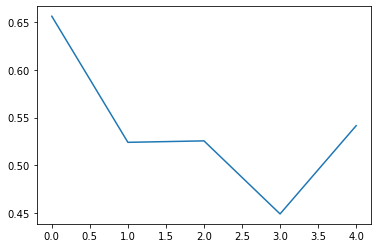

In [20]:
plt.plot(losses)

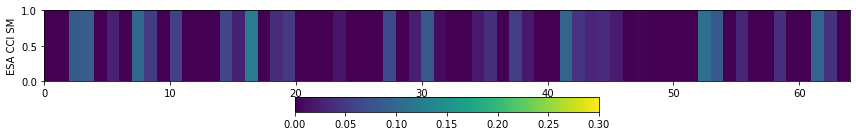

In [81]:
ws, bs = [p.detach().cpu().numpy() for p in lm.parameters()]

# weights = ws
f, ax = plt.subplots(figsize=(12, 2))
im = ax.pcolormesh(ws, vmin=0, vmax=0.3)
ax.set_ylabel(f"ESA CCI SM")

plt.colorbar(im, orientation='horizontal')
plt.tight_layout()

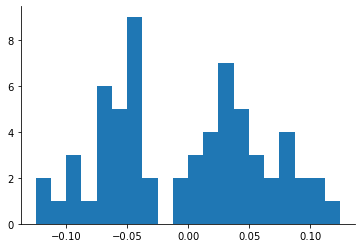

In [87]:
plt.hist(ws.flatten(), bins=20);
sns.despine()

# Calculate predictions

In [88]:
from collections import defaultdict
from scripts.cell_state.cell_state_model import to_xarray

model = lm
predictions = defaultdict(list)

model.eval()
with torch.no_grad():
    for data in tqdm(test_dl, desc="Forward Pass"):
        for key in [k for k in data.keys() if k != "meta"]:
            data[key] = data[key].to(device)

        y_hat = model(data).squeeze()
        y = data["y"][:, -1, :].squeeze()
        
        time = pd.to_datetime(data["meta"]["time"].numpy().astype("datetime64[ns]")[:, -1])
        spatial_unit = data["meta"]["spatial_unit"].numpy()

        #  Coords / Dimensions
        predictions["time"].extend((time))
        predictions["station_id"].extend(spatial_unit)

        # Variables
        predictions["y_hat"].extend(y_hat.detach().cpu().numpy().flatten())
        predictions["y"].extend(y.detach().cpu().numpy().flatten())

preds = to_xarray(predictions)

Forward Pass: 100%|██████████| 1746/1746 [00:10<00:00, 162.57it/s]


In [89]:
preds

<xarray.Dataset>
Dimensions:     (station_id: 670, time: 667)
Coordinates:
  * time        (time) datetime64[ns] 2007-03-04T23:58:57.877704704 ... 2008-...
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 101005 102001 106001
Data variables:
    y_hat       (time, station_id) float64 0.7109 0.1604 ... -0.009058 -0.5346
    y           (time, station_id) float64 -0.5492 -0.4197 ... -0.5555 -0.7349

In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
from scripts.read_nh_results import calculate_all_error_metrics

errors = calculate_all_error_metrics(
    preds, 
    basin_coord="station_id",
    time_coord="time",
    obs_var="y",
    sim_var="y_hat",
    metrics=["NSE", "Pearson-r"]
)

Calculating Errors:  39%|███▉      | 263/670 [00:02<00:04, 88.69it/s, 37001]


KeyboardInterrupt: 

Text(0.5, 0, 'Pearson-r')

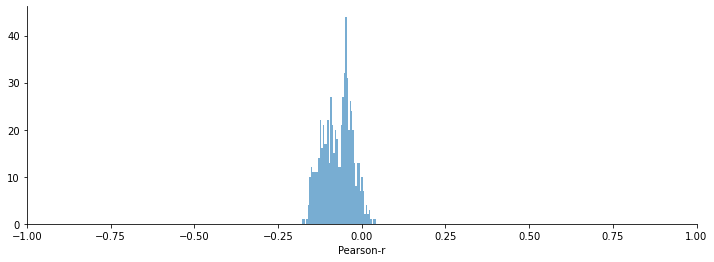

In [73]:
variable = "Pearson-r"
# variable = "NSE"

err = errors[variable].values

f, ax = plt.subplots(figsize=(12, 4))
ax.hist(err[np.isfinite(err)], alpha=0.6, bins=50);
# ax.axvline(0, ls="-", color="k", alpha=0.8)
ax.set_xlim(-1, 1)
sns.despine()
ax.set_xlabel(variable)

# Other Time series

In [ ]:
# TODO: AR1 process ?
# from statsmodels.tsa.arima_process import ArmaProcess
# https://towardsdatascience.com/time-series-forecasting-with-autoregressive-processes-ba629717401

norm = lambda x_t: (x_t - x_t.mean()) / x_t.std()

t = np.arange(100)
x_t = np.sin(t) + np.random.normal(10, 200, size=100)
x_t = norm(x_t)

vals = np.power(x_t, 2) + np.sin(x_t) + 3
vals = norm(vals)

plt.plot(vals)
sns.despine()
